In [15]:
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt

In [21]:
def process_data(filename):
    """
    Reads in a CSV file and encodes text columns. 
    Removes indret_ew, indret_vw from df. 
    Returns df (X matrix) and ew_indret (Y values )
    """
    df = pd.read_csv(filename, header=0, dtype={'public_date' : str})    
    df = df.dropna(axis=0)
        
    ew_indret = df['indret_ew']
    
    df = df.drop(labels=['indret_ew', 'indret_vw'], axis=1)  

    return df, ew_indret

def split_data(x, y): 
    """
    Splits data into 0.64 Train, 0.16 dev, 0.2 Test
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
    x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.2, shuffle = False)
    
    return x_train, x_test, x_dev, y_dev, y_train, y_test

def get_dates(x_train, x_dev, x_test):
    train_dates = [datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) for x in x_train['public_date']] 
    dev_dates = [datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) for x in x_dev['public_date']]
    test_dates = [datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) for x in x_test['public_date']]
    
    x_train = x_train.drop('public_date', axis=1)
    x_dev = x_dev.drop('public_date', axis=1)
    x_test = x_test.drop('public_date', axis=1)
    
    return train_dates, dev_dates, test_dates, x_train, x_dev, x_test

def test(model, x_train, y_train, x_dev, y_dev):
    y_train_predict = model.predict(x_train)
    train_mse = metrics.mean_squared_error(y_train, y_train_predict)
    
    y_dev_predict = model.predict(x_dev)
    mse = metrics.mean_squared_error(y_dev, y_dev_predict)
    r2 = metrics.r2_score(y_dev, y_dev_predict)
    
    return mse, y_train_predict, y_dev_predict

def graph(dates, y_real, y_pred=None):    
    plt.plot(dates, y_real, color='tab:green')
    plt.plot(dates, y_pred, color='tab:red')
    plt.show()

In [22]:
INDUSTRY_SET = {'FIN', 'HLTH', 'TOYS', 'SHIPS', 'MACH', 'AERO', 'STEEL', 'LABEQ', 'MEALS', 'RLEST', 'CLTHS', 
                'HSHLD', 'FOOD', 'PAPER', 'PERSV', 'BOXES', 'OTHER', 'TXTLS', 'BUSSV', 'MEDEQ', 'DRUGS', 
                'HARDW', 'WHLSL', 'SODA', 'INSUR', 'ELCEQ', 'RTAIL', 'FABPR', 'TRANS', 'FUN', 'RUBBR', 'SOFTW', 
                'GUNS', 'TELCM', 'CHEMS', 'AGRIC', 'BOOKS', 'COAL', 'SMOKE', 'OIL', 'GOLD', 'BLDMT', 'CNSTR', 'AUTOS', 
                'BANKS', 'UTIL', 'BEER', 'CHIPS', 'MINES'}

In [33]:
def train_GPR(x_train, y_train):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(x_train, y_train)
    return gpr

def train_LinearRegression(x_train, y_train):
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    return regr

def train_ElasticNet(alpha, l1, x_train, y_train, fix_intercept=True, normalize=True, maxiter=100000):
    reg = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1)
    reg.fit(x_train, y_train) 
    return reg

def train_Ridge(alpha, x_train, y_train):
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(x_train, y_train) 
    return reg

def train_Lasso(alpha, x_train, y_train):
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(x_train, y_train)
    return clf

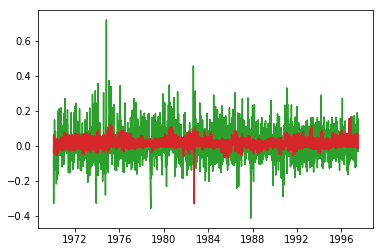

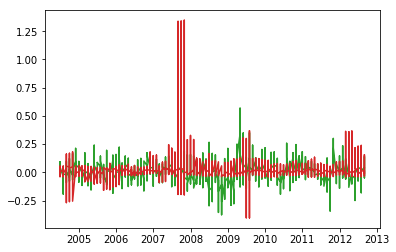

Training error: 0.0045468478058974075
Test error: 0.007385432322696895


In [30]:
def test_LinearRegression(): 

    df, ew_indret = process_data('FAMA_49CRSP.csv')

    x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret)
    train_dates, dev_dates, test_dates, x_train, x_dev, x_test = get_dates(x_train, x_dev, x_test)

    regr = train_LinearRegression(x_train, y_train)
    
    regr_train_pred = regr.predict(x_train)
    regr_test_pred = regr.predict(x_test)
    
    train_mse = metrics.mean_squared_error(y_train, regr_train_pred)
    test_mse = metrics.mean_squared_error(y_test, regr_test_pred)
    
    graph(train_dates, y_train, regr_train_pred)
    graph(test_dates, y_test, regr_test_pred)
                
    return train_mse, test_mse

linear_train_mse, linear_test_mse = test_LinearRegression()
print('Training error: {}'.format(linear_train_mse))
print('Test error: {}'.format(linear_test_mse))

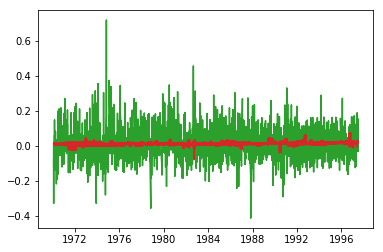

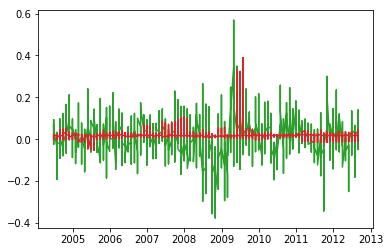

Training error: 0.004768258459560398
Test error: 0.005746681690470755


In [38]:
def test_Lasso(): 

    df, ew_indret = process_data('FAMA_49CRSP.csv')

    x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret)
    train_dates, dev_dates, test_dates, x_train, x_dev, x_test = get_dates(x_train, x_dev, x_test)

    regr = train_Lasso(0.01, x_train, y_train)
    
    lasso_train_pred = regr.predict(x_train)
    lasso_test_pred = regr.predict(x_test)
    
    train_mse = metrics.mean_squared_error(y_train, lasso_train_pred)
    test_mse = metrics.mean_squared_error(y_test, lasso_test_pred)
    
    graph(train_dates, y_train, lasso_train_pred)
    graph(test_dates, y_test, lasso_test_pred)
                
    return train_mse, test_mse

lasso_train_mse, lasso_test_mse = test_Lasso()
print('Training error: {}'.format(lasso_train_mse))
print('Test error: {}'.format(lasso_test_mse))

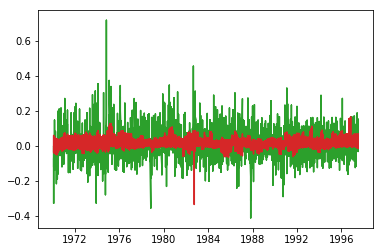

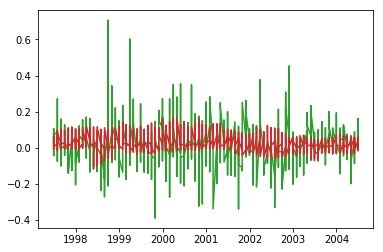

0.004549347474553706
0.007161755894814477
2.479999999999991


In [42]:
def find_ridge_alpha():
    df, ew_indret = process_data('FAMA_49CRSP.csv')
    df = encode(df, 'FFI49_desc')

    x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret)
    train_dates, dev_dates, test_dates, x_train, x_dev, x_test = get_dates(x_train, x_dev, x_test)

    prev_mse, ridge_dev_mse = 100, 99
    alpha = 0.01

    while prev_mse - ridge_dev_mse > 1e-8: 
        prev_mse = ridge_dev_mse
        Ridge = train_Ridge(alpha, x_train, y_train)

        ridge_dev_mse, ridge_train_pred, ridge_dev_pred = dev(Ridge, x_train, y_train, x_dev, y_dev)
        ridge_train_mse = metrics.mean_squared_error(y_train, ridge_train_pred)
        alpha += 0.01

    graph(train_dates, y_train, ridge_train_pred)
    graph(dev_dates, y_dev, ridge_dev_pred)

    print(ridge_train_mse)
    print(ridge_dev_mse)
    print(alpha)
    
    return alpha
    
alpha = find_ridge_alpha()

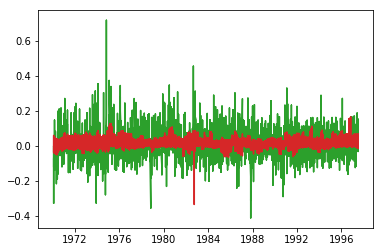

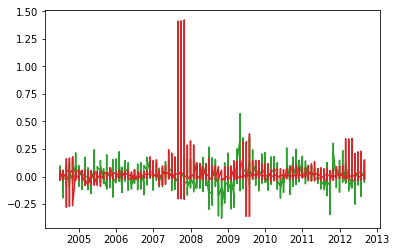

Training error: 0.004549357177795353
Test error: 0.007403930388895289


In [43]:
def test_Ridge(alpha): 

    df, ew_indret = process_data('FAMA_49CRSP.csv')

    x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret)
    train_dates, dev_dates, test_dates, x_train, x_dev, x_test = get_dates(x_train, x_dev, x_test)

    Ridge = train_Ridge(alpha, x_train, y_train)
    
    Ridge_train_pred = Ridge.predict(x_train)
    Ridge_test_pred = Ridge.predict(x_test)
    
    train_mse = metrics.mean_squared_error(y_train, Ridge_train_pred)
    test_mse = metrics.mean_squared_error(y_test, Ridge_test_pred)
    
    graph(train_dates, y_train, Ridge_train_pred)
    graph(test_dates, y_test, Ridge_test_pred)
                
    return train_mse, test_mse

Ridge_train_mse, Ridge_test_mse = test_Ridge(alpha)
print('Training error: {}'.format(Ridge_train_mse))
print('Test error: {}'.format(Ridge_test_mse))

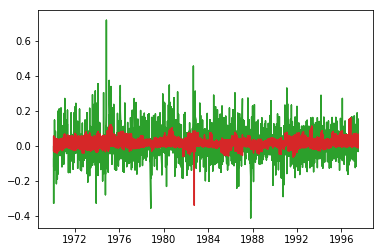

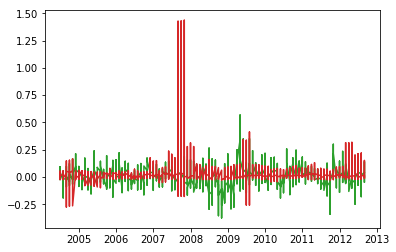

Training error: 0.004560157369256608
Test error: 0.007369987364990421


In [28]:
def test_ElasticNet(): 

    df, ew_indret = process_data('FAMA_49CRSP.csv')

    x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret)
    train_dates, dev_dates, test_dates, x_train, x_dev, x_test = get_dates(x_train, x_dev, x_test)

    ElasticNet = train_ElasticNet(0.001, 0.01, x_train, y_train)
    
    EN_train_pred = ElasticNet.predict(x_train)
    EN_test_pred = ElasticNet.predict(x_test)
    
    train_mse = metrics.mean_squared_error(y_train, EN_train_pred)
    test_mse = metrics.mean_squared_error(y_test, EN_test_pred)
    
    graph(train_dates, y_train, EN_train_pred)
    graph(test_dates, y_test, EN_test_pred)
                
    return train_mse, test_mse

EN_train_mse, EN_test_mse = test_ElasticNet()
print('Training error: {}'.format(EN_train_mse))
print('Test error: {}'.format(EN_test_mse))